In [25]:
import os
import sys
import torch
import pytorch3d

In [41]:
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere, torus
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [3]:
%matplotlib notebook 

In [4]:
device

device(type='cuda', index=0)

In [29]:
trg_obj = 'dolphin.obj'
trg_verts, trg_faces, trg_aux = load_obj(trg_obj)
print(trg_verts.shape)
# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
trg_faces_idx = trg_faces.verts_idx.to(device)
trg_verts = trg_verts.to(device)
print(trg_faces_idx.shape)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = trg_verts.mean(0)
verts = trg_verts - center
scale = max(trg_verts.abs().max(0)[0])
verts = trg_verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[trg_verts], faces=[trg_faces_idx])


torch.Size([2562, 3])
torch.Size([5120, 3])


/opt/conda/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [9]:
# Load a source Mesh
src_obj = 'chair.obj'
src_verts, src_faces, src_aux = load_obj(src_obj)
print(src_verts.shape)
# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
src_faces_idx = src_faces.verts_idx #.to(device)
src_verts = src_verts #.to(device)
print(src_faces_idx.shape)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = src_verts.mean(0)
verts = src_verts - center
scale = max(src_verts.abs().max(0)[0])
verts = src_verts / scale

# We construct a Meshes structure for the target mesh
# src_mesh = Meshes(verts=[src_verts], faces=[src_faces_idx])

torch.Size([1918, 3])
torch.Size([3812, 3])


In [30]:
src_subset_verts = verts[:int(len(src_verts)/2)]
src_subset_faces = []
for face in src_faces.verts_idx:
  for face_v in face:
    if(face_v > len(src_subset_verts)/2):
      continue
    src_subset_faces.append(list(face))

In [32]:
src_subset_faces

[[tensor(1), tensor(2), tensor(0)],
 [tensor(1), tensor(2), tensor(0)],
 [tensor(1), tensor(2), tensor(0)],
 [tensor(3), tensor(4), tensor(0)],
 [tensor(3), tensor(4), tensor(0)],
 [tensor(3), tensor(4), tensor(0)],
 [tensor(3), tensor(0), tensor(2)],
 [tensor(3), tensor(0), tensor(2)],
 [tensor(3), tensor(0), tensor(2)],
 [tensor(5), tensor(4), tensor(3)],
 [tensor(5), tensor(4), tensor(3)],
 [tensor(5), tensor(4), tensor(3)],
 [tensor(7), tensor(8), tensor(6)],
 [tensor(7), tensor(8), tensor(6)],
 [tensor(7), tensor(8), tensor(6)],
 [tensor(9), tensor(10), tensor(6)],
 [tensor(9), tensor(10), tensor(6)],
 [tensor(9), tensor(10), tensor(6)],
 [tensor(9), tensor(6), tensor(8)],
 [tensor(9), tensor(6), tensor(8)],
 [tensor(9), tensor(6), tensor(8)],
 [tensor(11), tensor(12), tensor(10)],
 [tensor(11), tensor(12), tensor(10)],
 [tensor(11), tensor(12), tensor(10)],
 [tensor(11), tensor(10), tensor(9)],
 [tensor(11), tensor(10), tensor(9)],
 [tensor(11), tensor(10), tensor(9)],
 [tensor(1

In [34]:
src_subset_faces = torch.from_numpy(np.array(src_subset_faces))
src_subset_faces = src_subset_faces.to(device)
src_subset_verts = src_subset_verts.to(device)

In [35]:
partial_src_mesh = Meshes(verts=[src_subset_verts], faces=[src_subset_faces])

In [36]:
# Fetch the verts and faces of the source mesh
initial_verts, initial_faces = partial_src_mesh.get_mesh_verts_faces(0)


# Store the original mesh using save_obj
org_obj = 'test_partial.obj'
save_obj(org_obj, initial_verts, initial_faces)

In [37]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title("title")
    ax.view_init(190, 30)
    return plt

In [14]:
plt = plot_pointcloud(trg_mesh, "Target mesh")
plt.show()

<IPython.core.display.Javascript object>

In [15]:
plot_pointcloud(src_mesh, "Source mesh")

<IPython.core.display.Javascript object>

<module 'matplotlib.pyplot' from '/opt/conda/envs/reconstruct/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [38]:
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(partial_src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

In [39]:
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

In [43]:
# Number of optimization steps
Niter = 2000
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = partial_src_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)
        
    # Optimization step
    loss.backward()
    optimizer.step()

total_loss = 0.010362: 100%|██████████| 2000/2000 [00:38<00:00, 51.93it/s]


<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

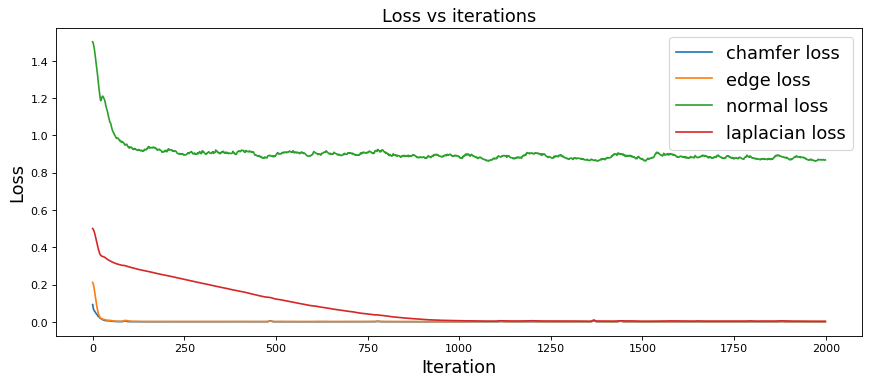

In [44]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");

In [46]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = 'model_2.obj'
save_obj(final_obj, final_verts, final_faces)